# hw12

1. 生成 N (0, 1) 的 200 个随机样本,

(1) 做直方图；

(2) 根据这些数据, 尝试不同的窗宽, 得到核密度估计的最优窗宽；

(3) 计算得到的核密度估计和真实密度之间的差异.

In [7]:
import numpy as np
import pandas as pd

np.random.seed(42)  # 为可重复性设置随机种子
samples = np.random.normal(loc=0, scale=1, size=200)


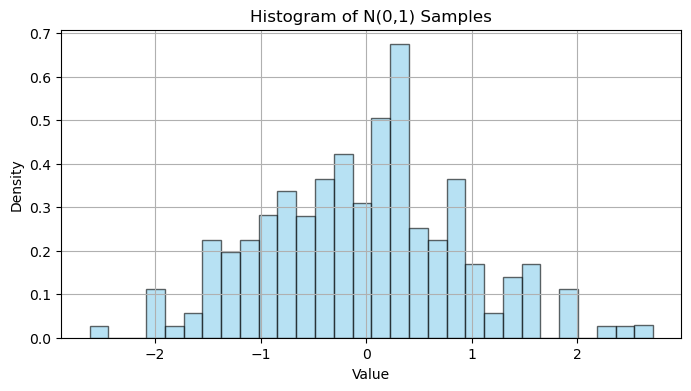

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(samples, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
plt.title('Histogram of N(0,1) Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()


最佳窗宽（带宽）：0.4379


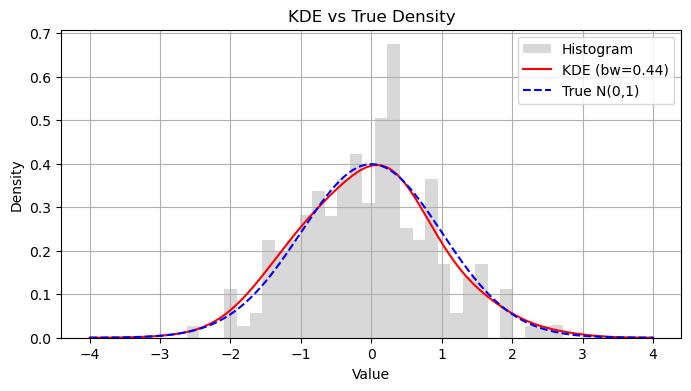

In [9]:
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# 使用 sklearn 进行带宽优化（交叉验证）
bandwidths = np.linspace(0.1, 1.5, 30)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)
grid.fit(samples[:, None])

optimal_bandwidth = grid.best_params_['bandwidth']
print(f"最佳窗宽（带宽）：{optimal_bandwidth:.4f}")

# 用最优带宽绘制 KDE
kde = KernelDensity(kernel='gaussian', bandwidth=optimal_bandwidth).fit(samples[:, None])
x_plot = np.linspace(-4, 4, 1000)[:, None]
log_dens = kde.score_samples(x_plot)
kde_density = np.exp(log_dens)

plt.figure(figsize=(8, 4))
plt.hist(samples, bins=30, density=True, alpha=0.3, color='gray', label='Histogram')
plt.plot(x_plot[:, 0], kde_density, color='red', label=f'KDE (bw={optimal_bandwidth:.2f})')
plt.plot(x_plot[:, 0], (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x_plot[:, 0]**2), '--', color='blue', label='True N(0,1)')
plt.title('KDE vs True Density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from sklearn.metrics import mean_squared_error

true_density = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x_plot[:, 0]**2)
mse = mean_squared_error(true_density, kde_density)
print(f"KDE 与真实密度的 MSE：{mse:.6f}")


KDE 与真实密度的 MSE：0.000109


5. 下面是某车间生产的一批轴的实际直径 (单位:mm):

9.967, 10.001, 9.994, 10.023, 9.969, 10.013, 9.992, 9.954, 9.934, 9.965

分别用 Kolmogorov-Smirnov 检验和 χ2 拟合检验, 检验该尺寸是否服

从均值为 10, 标准差为0.022 的正态分布?

In [11]:
import numpy as np
from scipy import stats
data = np.array([9.967, 10.001, 9.994, 10.023, 9.969, 
                 10.013, 9.992, 9.954, 9.934, 9.965])

mu = 10
sigma = 0.022

ks_statistic, ks_pvalue = stats.kstest(data, 'norm', args=(mu, sigma))
print(f"K-S检验: 统计量 = {ks_statistic:.4f}, p值 = {ks_pvalue:.4f}")
if ks_pvalue < 0.05:
    print("拒绝原假设：数据不服从正态分布")
else:
    print("未拒绝原假设：数据服从正态分布")

K-S检验: 统计量 = 0.4206, p值 = 0.0406
拒绝原假设：数据不服从正态分布


In [12]:
bins = np.linspace(min(data)-0.01, max(data)+0.01, 5)  

In [13]:
observed_freq, _ = np.histogram(data, bins=bins)

# 计算每个区间的期望频数
# 期望频数 = 样本数 * 区间内概率
cdf_vals = stats.norm.cdf(bins, loc=mu, scale=sigma)
expected_probs = np.diff(cdf_vals)
expected_freq = expected_probs * len(data)
expected_freq = expected_freq / expected_freq.sum() * len(data)
# 卡方检验
chi2_stat, chi2_pvalue = stats.chisquare(observed_freq, f_exp=expected_freq)

print("\n卡方拟合优度检验结果:")
print(f"统计量 = {chi2_stat:.4f}, p值 = {chi2_pvalue:.4f}")
print(f"观测频数: {observed_freq}")
print(f"期望频数: {expected_freq.round(2)}")
if chi2_pvalue < 0.05:
    print("拒绝原假设：数据不服从正态分布")
else:
    print("未拒绝原假设：数据服从正态分布")


卡方拟合优度检验结果:
统计量 = 10.0735, p值 = 0.0180
观测频数: [1 4 3 2]
期望频数: [0.14 1.62 4.7  3.54]
拒绝原假设：数据不服从正态分布


6. 从正态分布 N (1, 4) 中随机产生 n 个随机样本. 对于 n = 10, 20, 30,

50 等不同情形, 分别用 Kolmogorov-Smirnov 检验和 χ2 拟合检验, 检

验该样本是否服从正态分布. 重复前面的过程 100 次, 试分析随着样本

量 n 的提高, 拒绝样本服从正态分布的概率的变化情况.

In [14]:
np.random.seed(42)  

mu, sigma = 1, 2  # N(1,4) -> std = 2
sample_sizes = [10, 20, 30, 50]
repeat_times = 100

rej_rate_ks = []
rej_rate_chi2 = []

for n in sample_sizes:
    rej_ks_count = 0
    rej_chi2_count = 0
    
    for _ in range(repeat_times):
        # 生成样本
        data = np.random.normal(mu, sigma, n)
        
        # K-S
        ks_stat, ks_pvalue = stats.kstest(data, 'norm', args=(mu, sigma))
        if ks_pvalue < 0.05:
            rej_ks_count += 1
        
        # chisquare
        bin_count = max(4, int(np.sqrt(n)))
        bins = np.linspace(min(data)-0.01, max(data)+0.01, bin_count + 1)
        observed_freq, _ = np.histogram(data, bins=bins)
        
        cdf_vals = stats.norm.cdf(bins, loc=mu, scale=sigma)
        expected_probs = np.diff(cdf_vals)
        expected_freq = expected_probs * n
        expected_freq = expected_freq / expected_freq.sum() * n  # 归一化
        
        # 判断期望频数是否满足要求，若不满足，跳过此次卡方检验（不计入拒绝次数）
        chi2_stat, chi2_pvalue = stats.chisquare(observed_freq, f_exp=expected_freq)
        if chi2_pvalue < 0.05:
            rej_chi2_count += 1

    rej_rate_ks.append(rej_ks_count / repeat_times)
    rej_rate_chi2.append(rej_chi2_count / repeat_times)

print("样本量:", sample_sizes)
print("KS检验拒绝率:", rej_rate_ks)
print("卡方检验拒绝率:", rej_rate_chi2)


样本量: [10, 20, 30, 50]
KS检验拒绝率: [0.05, 0.06, 0.03, 0.03]
卡方检验拒绝率: [0.05, 0.05, 0.08, 0.07]


7. 美国在 1995 年因几种违法而被捕的人数按照性别为:

性别    男  女

谋杀13927   1457

抢劫116741  12068

恶性攻击328476  70938

偷盗236495  29866

非法侵占704565  351580

偷盗机动车119175    18058

纵火11413   2156

从这些罪行的组合看来, 是否与性别无关? 如果只考虑谋杀与抢劫罪,结论是否一样?

In [19]:
from scipy.stats import chi2_contingency
# 构建列联表数据
data = {
    '男': [13927, 116741, 328476, 236495, 704565, 119175, 11413],
    '女': [1457, 12068, 70938, 29866, 351580, 18058, 2156]
}
crime_types = ['谋杀', '抢劫', '恶性攻击', '偷盗', '非法侵占', '偷盗机动车', '纵火']
df = pd.DataFrame(data, index=crime_types)
df


,男,女
谋杀,13927,1457
抢劫,116741,12068
恶性攻击,328476,70938
偷盗,236495,29866
非法侵占,704565,351580
偷盗机动车,119175,18058
纵火,11413,2156


In [20]:

# 卡方检验
chi2, p, dof, expected = chi2_contingency(df)

print("全表卡方独立性检验结果:")
print(f"卡方统计量: {chi2:.4f}, 自由度: {dof}, p值: {p:.4f}")
if p<0.05:
    print("拒绝原假设：性别与犯罪类型不独立")
else:
    print("未拒绝原假设：性别与犯罪类型独立")


全表卡方独立性检验结果:
卡方统计量: 108268.6442, 自由度: 6, p值: 0.0000
拒绝原假设：性别与犯罪类型不独立


In [22]:
df_small = df.loc[['谋杀', '抢劫']]

chi2_small, p_small, dof_small, expected_small = chi2_contingency(df_small)

print("\n仅谋杀与抢劫罪的卡方独立性检验结果:")
print(f"卡方统计量: {chi2_small:.4f}, 自由度: {dof_small}, p值: {p_small:.4f}")
if p_small<0.05:
    print("拒绝原假设：性别与犯罪类型不独立")
else:
    print("未拒绝原假设：性别与犯罪类型独立")



仅谋杀与抢劫罪的卡方独立性检验结果:
卡方统计量: 0.1563, 自由度: 1, p值: 0.6926
未拒绝原假设：性别与犯罪类型独立


10. 调查某公司产品在两个不同国家的认可程度, 被调查人员对该产品打分结果如下:

国家 A：21 34 56 45 58 80 32 46 50 21 11 18 38 52 47 19 60 57 72 82
29 25 89 46 39 29 67 75 31 48 45

国家 B：68 77 51 51 64 43 41 20 44 57 60 82 86 92 54 33 18 39 52 66
78 77 54 63 48 40 29 56 45 21 50 48 20

取 $\alpha = 0.05$, 问该公司产品在两个国家认可程度有无差别.

In [26]:
# 数据
country_A = [21, 34, 56, 45, 58, 80, 32, 46, 50, 21, 11, 18, 38, 52, 47, 19, 60, 57, 72, 82,
             29, 25, 89, 46, 39, 29, 67, 75, 31, 48, 45]
country_B = [68, 77, 51, 51, 64, 43, 41, 20, 44, 57, 60, 82, 86, 92, 54, 33, 18, 39, 52, 66,
             78, 77, 54, 63, 48, 40, 29, 56, 45, 21, 50, 48, 20]

# 独立样本 t 检验（等方差假设）
t_stat, p_value = stats.ttest_ind(country_A, country_B, equal_var=False)

print("独立样本 t 检验结果:")
print(f"t 统计量 = {t_stat:.4f}, p 值 = {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("结论：拒绝原假设，两个国家的认可程度存在显著差异。")
else:
    print("结论：不拒绝原假设，两个国家的认可程度没有显著差异。")


独立样本 t 检验结果:
t 统计量 = -1.2926, p 值 = 0.2010
结论：不拒绝原假设，两个国家的认可程度没有显著差异。


11. 假设总体 $X ∼ N (0, \sigma^2 )$, 总体 $Y ∼ N (\theta, \sigma^2 )$, 其中 $\theta$ 和 $\sigma^2$ 为未知参数. 对假设检验问题$ H_0:\theta = 0  \quad \text{vs.} \quad H_1:\theta > 0$, 使用计算机从两个总体中分别生成100个随机数,

(1) 在重复随机数意义下, 考察 Wilcoxon 秩和检验在$\theta$ = 0.1, 0.5, 1, 1.5
时的拒绝率；

(2) 对比两样本 t 检验方法, 你能得出什么结论?

In [18]:
n = 100  # 每组样本数量
alpha = 0.05
num_trials = 100  # 重复实验次数
theta_vals = [0.1, 0.5, 1.0, 1.5]

print("θ 值\tWilcoxon 拒绝率\tT检验 拒绝率")
for theta in theta_vals:
    wilcoxon_rejects = 0
    ttest_rejects = 0

    for _ in range(num_trials):
        x = np.random.normal(0, 1, n)
        y = np.random.normal(theta, 1, n)

        # Wilcoxon 秩和检验（ranksums，适用于独立样本）
        w_stat, w_p = stats.ranksums(x, y)
        if w_p < alpha:
            wilcoxon_rejects += 1

        # 独立样本 t 检验（双尾检验中转换为单尾）
        t_stat, t_p = stats.ttest_ind(x, y, equal_var=True)
        t_p_one_sided = t_p / 2 if t_stat > 0 else 1 - t_p / 2
        if t_p_one_sided < alpha:
            ttest_rejects += 1

    print(f"{theta:<4}\t{wilcoxon_rejects/num_trials:.2f}\t\t{ttest_rejects/num_trials:.2f}")


θ 值	Wilcoxon 拒绝率	T检验 拒绝率
0.1 	0.12		0.02
0.5 	0.89		0.00
1.0 	1.00		0.00
1.5 	1.00		0.00
